In [4]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')
import corner
from sklearn.decomposition import FastICA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


In [6]:
pip install torch


     |████████████████████████████████| 68.6 MB 2.2 MB/s eta 0:00:011
     |████████████████████████████████| 1.6 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 134 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 6.3 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 199 kB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 536 kB 2.0 MB/s eta 0:00:01
You should consider upgrading via the '/Users/daniele/kerasenv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata

from astroML.datasets import fetch_sdss_specgals
from astroML.utils.decorators import pickle_results

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim

In [8]:
import pandas as pd

df = pd.read_csv('../solutions/galaxyquasar.csv')
print(df.head())
data = df.to_numpy() # Convert to numpy array


          u         g         r         i         z   class        z1  \
0  18.97213  18.53676  18.58280  18.34936  18.29215     QSO  0.522819   
1  19.24592  17.47646  16.47817  16.04472  15.68851  GALAXY  0.122846   
2  19.43536  17.70268  16.91565  16.58327  16.39128  GALAXY  0.000000   
3  19.31626  18.18312  17.39591  16.94549  16.65395  GALAXY  0.147435   
4  19.28828  19.11188  18.88937  18.80013  18.49183     QSO  2.011455   

       zerr  
0  0.000155  
1  0.000028  
2  0.000000  
3  0.000009  
4  0.000631  


In [9]:
u=data[:,0]
g=data[:,1]
r=data[:,2]
i=data[:,3]
z=data[:,4]
class_=data[:,5]
z1=data[:,6]
zerr=data[:,7]

In [10]:
u_g=u-g
g_r=g-r
r_i=r-i
i_z=i-z

In [11]:
X = np.column_stack([u_g, g_r, r_i, i_z])

y_raw = data[:, 5]
y = np.where(y_raw == 'GALAXY', 0, 1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Now concatenate normalized features with the target labels as the last column
datanormed = np.column_stack([X_scaled, y])

#Converts the data to PyTorch tensors
X_tensor = torch.tensor(datanormed[:, 0:4], dtype=torch.float32)
y_tensor = torch.tensor(datanormed[:, 4], dtype=torch.float32).view(-1,1)

# Create the PyTorch dataset
dataset = TensorDataset(X_tensor, y_tensor)

In [12]:
trainnum = int(0.7 * datanormed.shape[0]) #Calculates the number of samples to use for training and testing
testnum = datanormed.shape[0] - trainnum

traindata, testdata = torchdata.random_split(dataset, [trainnum, testnum]) #Splits the dataset into two random subsets

In [13]:
traindataloader = torchdata.DataLoader(traindata, 
                                       batch_size=128, 
                                       shuffle=True) #The shuffle=True means it will randomly shuffle the training data at the start of each epoch
test_loader = DataLoader(testdata, batch_size=128, shuffle=False) #shuffle=False because during testing you usually keep the order fixed

In [14]:
class Net(nn.Module):
    def __init__(self, nhidden):
        super(Net, self).__init__()
        self.fc_h = nn.Linear(4, nhidden)
        self.fc_o = nn.Linear(nhidden, 1)

    def forward(self, x):
        h = F.relu(self.fc_h(x))
        z = self.fc_o(h)
        return z

In [15]:
# Instantiate the model with 5 hidden neurons
model = Net(nhidden=5)

# Adam optimizer with learning rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Binary Cross Entropy Loss for binary classification
criterion = nn.BCEWithLogitsLoss()

Epoch 0, Average training loss: 0.5517
Epoch 10, Average training loss: 0.0729
Epoch 20, Average training loss: 0.0694
Epoch 30, Average training loss: 0.0677
Epoch 40, Average training loss: 0.0646


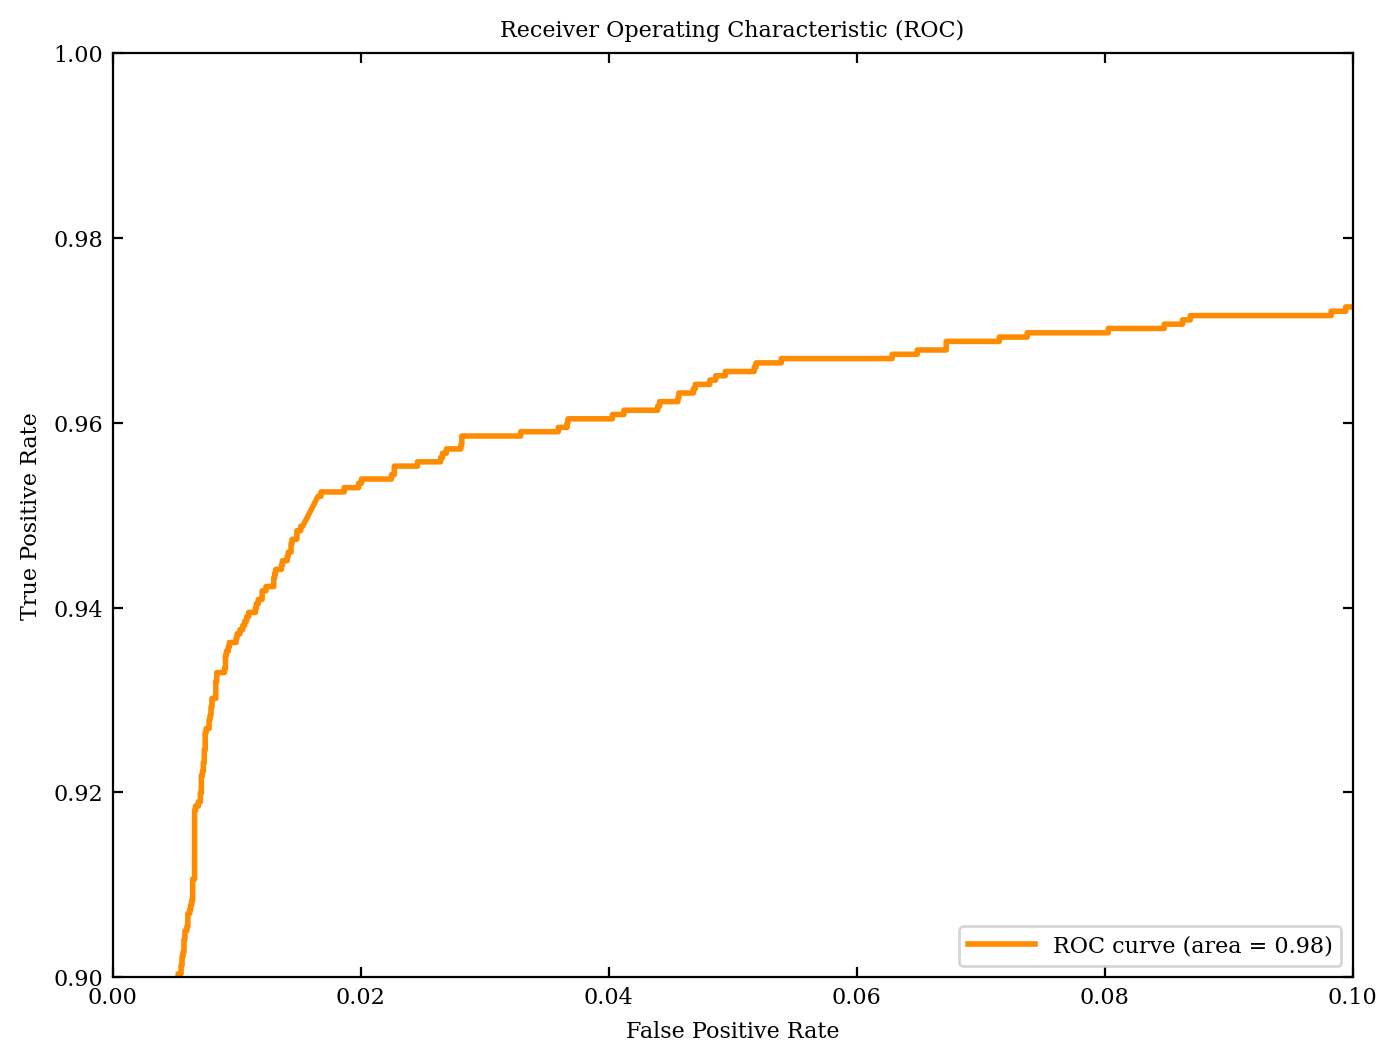

In [16]:

# Training loop for 50 epochs
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = 0.0
    for inputs, targets in traindataloader:
        optimizer.zero_grad()             # reset gradients
        outputs = model(inputs)           # forward pass
        loss = criterion(outputs, targets)# compute loss
        loss.backward()                   # backpropagation
        optimizer.step()                  # update weights
        train_loss += loss.item()
    
    if epoch % 10 == 0:
        avg_loss = train_loss / len(traindataloader)
        print(f"Epoch {epoch}, Average training loss: {avg_loss:.4f}")

# ROC curve calculation on the test set
model.eval()  # set model to evaluation mode
y_probs = []
y_true = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        y_probs.extend(outputs.numpy())
        y_true.extend(targets.numpy())

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlim(0,0.1)
plt.ylim(0.9,1)
plt.legend(loc="lower right")
plt.show()


Hyperparameter optimization: we use keras in order to use gridsearch in the cross validation process

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_small, _, y_small, _ = train_test_split(X_scaled, y, test_size=0.8, random_state=42)
print("Subset shape:", X_small.shape, X_scaled.shape)

Subset shape: (10000, 4) (50000, 4)


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout #dense connects neurons in the previous layer to the next layer, dropout is a regularization technique
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
print(KerasClassifier)

<class 'scikeras.wrappers.KerasClassifier'>


In [19]:
import scikeras
import sklearn
import tensorflow as tf

print("scikeras:", scikeras.__version__)
print("sklearn:", sklearn.__version__)
print("tensorflow:", tf.__version__)

scikeras: 0.13.0
sklearn: 1.6.1
tensorflow: 2.19.0


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV


#we run cross validation on a small subset of the data to speed up the process
X_small, _, y_small, _ = train_test_split(X_scaled, y, test_size=0.8, random_state=42)
print("Subset shape:", X_small.shape, X_scaled.shape)

#wrapper definition
class CustomKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden=5, activation='relu', dropout=0.0, 
                 optimizer='adam', learning_rate=0.001, 
                 epochs=10, batch_size=128):
        self.n_hidden = n_hidden
        self.activation = activation
        self.dropout = dropout
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model_ = None

    def build_model(self):
        model = Sequential()
        model.add(Dense(self.n_hidden, input_dim=4, activation=self.activation))
        if self.dropout > 0:
            model.add(Dropout(self.dropout))
        model.add(Dense(1, activation='sigmoid'))

        if self.optimizer == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        elif self.optimizer == 'sgd':
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
        else:
            raise ValueError("Unsupported optimizer")

        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model

    def fit(self, X, y):
        self.model_ = self.build_model()
        self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        y_pred_proba = self.model_.predict(X, verbose=0)
        return (y_pred_proba > 0.5).astype(int).flatten()

    def predict_proba(self, X):
        y_pred_proba = self.model_.predict(X, verbose=0)
        return np.hstack([1 - y_pred_proba, y_pred_proba])

# --------------------
# GRID SEARCH
# --------------------
param_grid = {
    'n_hidden': [4,5,6, 7, 8, 9, 10],
    'activation': ['relu', 'tanh'],
    'dropout': [0.0, 0.1, 0.2, 0.3],
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1]
}

grid = GridSearchCV(estimator=CustomKerasClassifier(epochs=10, batch_size=128),
                    param_grid=param_grid,
                    scoring='roc_auc', cv=3, verbose=2)


grid_result = grid.fit(X_small, y_small)

#results 
print("Best params:", grid_result.best_params_)

Subset shape: (10000, 4) (50000, 4)
Fitting 3 folds for each of 560 candidates, totalling 1680 fits
[CV] END activation=relu, dropout=0.0, learning_rate=0.001, n_hidden=4, optimizer=adam; total time=   0.6s
[CV] END activation=relu, dropout=0.0, learning_rate=0.001, n_hidden=4, optimizer=adam; total time=   0.6s
[CV] END activation=relu, dropout=0.0, learning_rate=0.001, n_hidden=4, optimizer=adam; total time=   0.6s
[CV] END activation=relu, dropout=0.0, learning_rate=0.001, n_hidden=4, optimizer=sgd; total time=   0.4s
[CV] END activation=relu, dropout=0.0, learning_rate=0.001, n_hidden=4, optimizer=sgd; total time=   0.4s
[CV] END activation=relu, dropout=0.0, learning_rate=0.001, n_hidden=4, optimizer=sgd; total time=   0.4s
[CV] END activation=relu, dropout=0.0, learning_rate=0.001, n_hidden=5, optimizer=adam; total time=   0.5s
[CV] END activation=relu, dropout=0.0, learning_rate=0.001, n_hidden=5, optimizer=adam; total time=   0.5s
[CV] END activation=relu, dropout=0.0, learning

once we have the best hyperparameters, we can train our classifier with them and compute the roc curve and the accuracy

Test Accuracy: 0.982


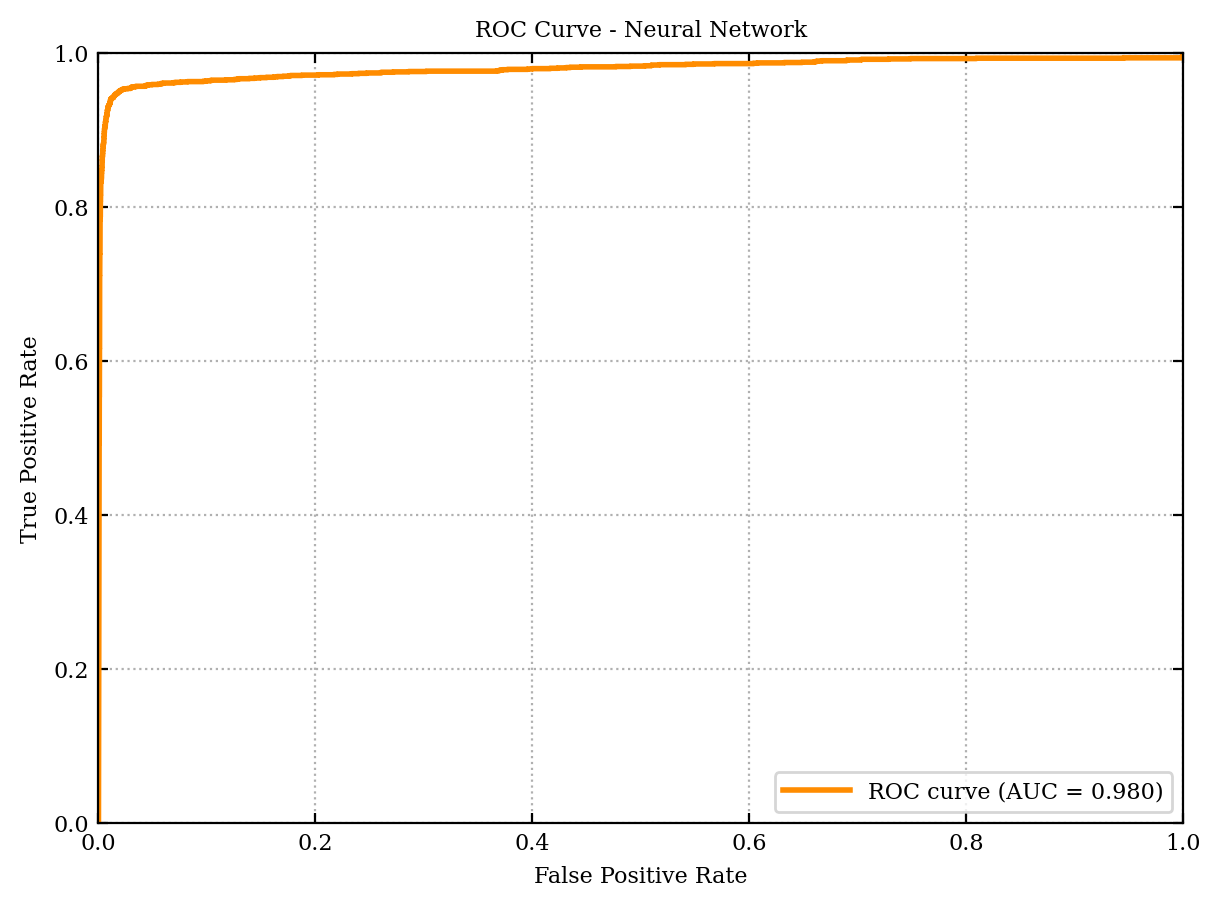

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y)

best_model = CustomKerasClassifier(
    n_hidden=4,
    activation='relu',
    dropout=0.0,
    learning_rate=0.001,
    optimizer='adam',
    epochs=50,
    batch_size=128
)

best_model.fit(X_train, y_train)

y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# 4. Accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")

# 5. ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# 6. Plot ROC
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Now we use RandomForestClassifier and we compute the accuracy as well

Random Forest Test Accuracy: 0.985


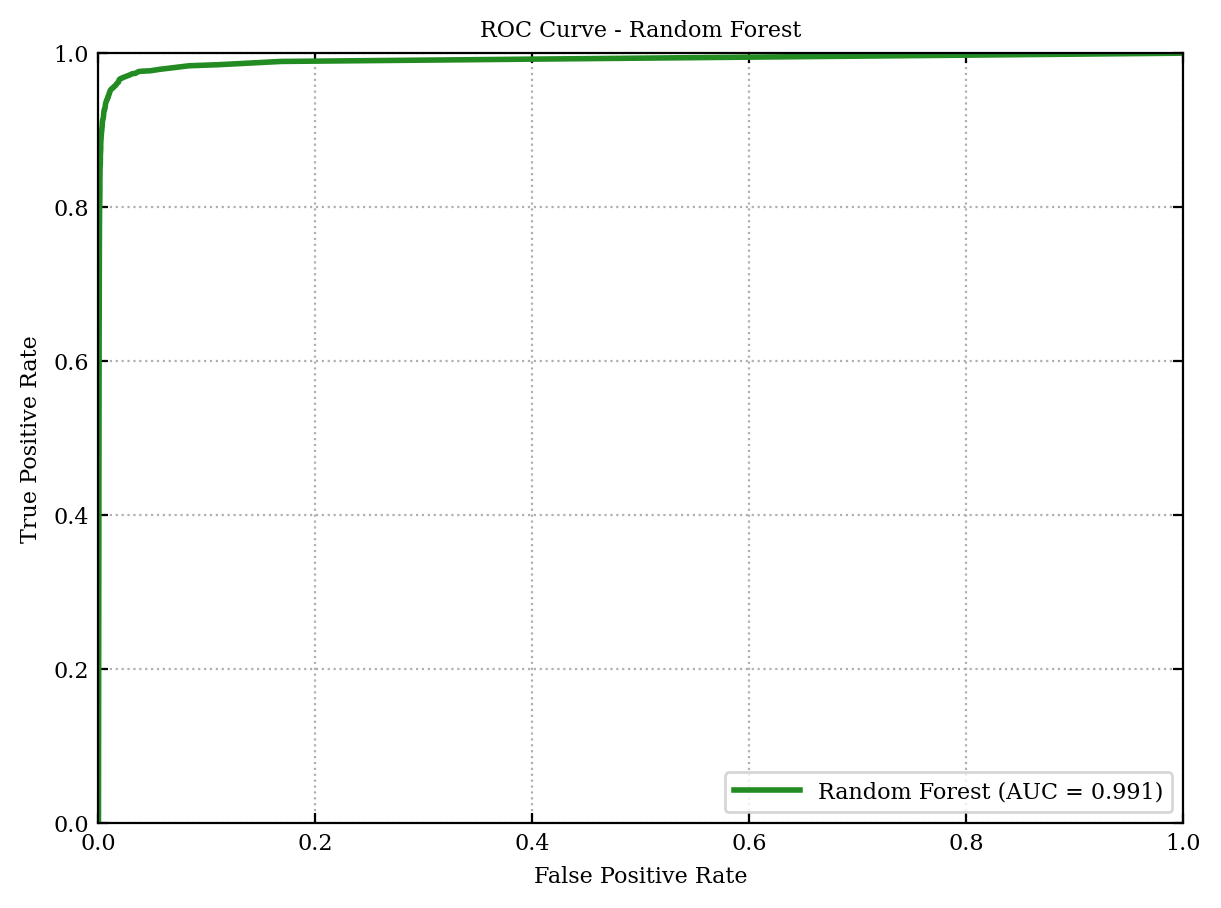

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf.fit(X_train, y_train)

y_prob_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Test Accuracy: {acc_rf:.3f}")

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(7,5))
plt.plot(fpr_rf, tpr_rf, color='forestgreen', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


The accuracy is bigger then the Keras's one. We can conclude that deep learning for this case is not necessary

we even compare the two roc curve in order to reinforce this conclusion

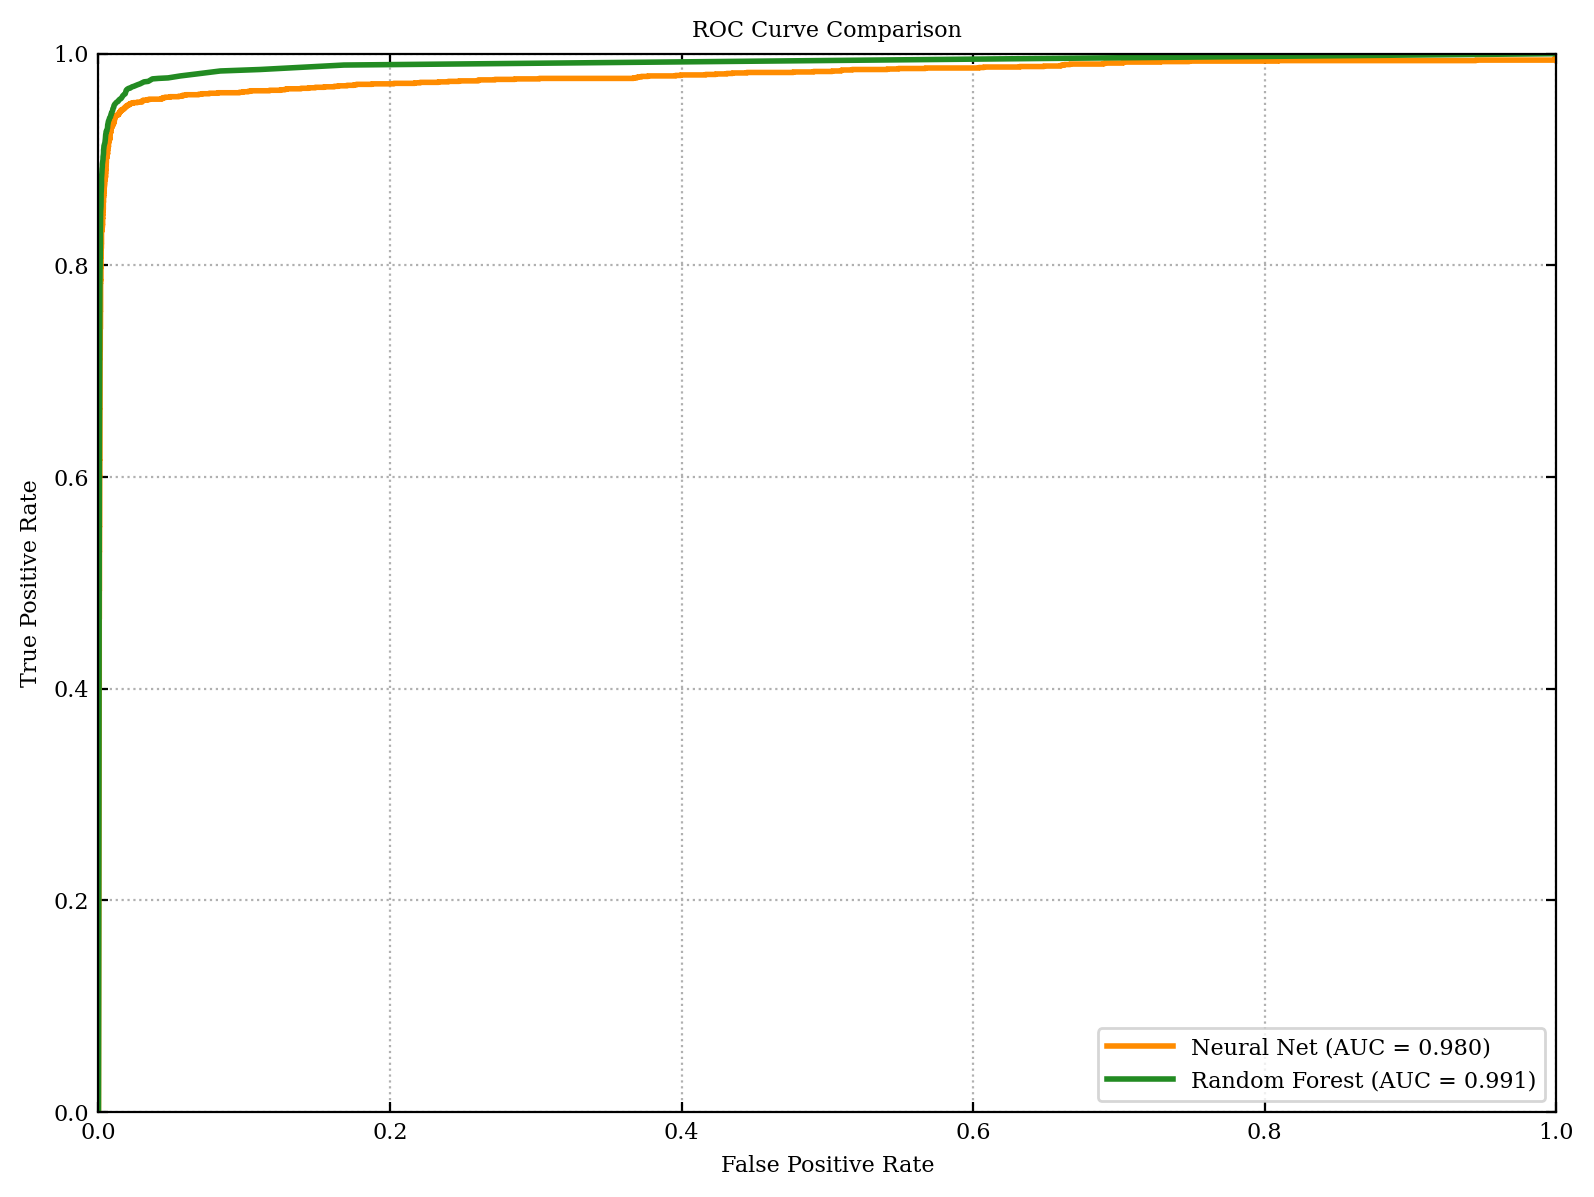

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob)
roc_auc_nn = auc(fpr_nn, tpr_nn)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_nn, tpr_nn, color='darkorange', lw=2, label=f'Neural Net (AUC = {roc_auc_nn:.3f})')
plt.plot(fpr_rf, tpr_rf, color='forestgreen', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
